2036 rows that have undefined values

In [146]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import IsolationForest
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from numpy.fft import fft, fftfreq
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [147]:
def csv_to_df_concatenator(list_of_paths, axis=None, **kwargs):
    '''
    given a list of paths, it will load all those CSV files and concatenate them 
    based on column names and axis if given 0 or 1.
    kwargs may also be passed to use when reading the files.
    '''
    output_dfs = []
    for csv_file in list_of_paths:
        small_df = pd.read_csv(csv_file, **kwargs)
        output_dfs.append(small_df)
    if axis is not None:
        return pd.concat(output_dfs, axis=axis)
    else:
        return pd.concat(output_dfs)
    
def normalize_segments(df, indices, cols_ignore=[]):
    df_ignore = df[cols_ignore]
    time_col = df['TimeStr']
    df = df[["34-2-V-O-O", "35-3-V-O-B", "38-6-WIS-O", "39-7-WIS-B", 
          "36-4-V-B-O", "37-5-V-B-B", "40-8-OMG", "33-1-Olie"]]
    out = []
    time_out = []
    ignore_out = []
    for start, end in zip(indices[:-1], indices[1:]):
        seg = df.iloc[start:end].copy()
        ignore_out_seg = df_ignore.iloc[start:end].copy()
        time_col_seg = time_col.iloc[start:end].copy()
        seg = (seg - seg.mean()) / seg.std()
        out.append(seg)
        time_out.append(time_col_seg)
        ignore_out.append(ignore_out_seg)
    return pd.concat(out), pd.concat(time_out), pd.concat(ignore_out)

def assign_machine_runs(df, gap_indices):

    # copy so you don't mutate original
    df_out = df.copy()
    
    gap_indices = sorted(gap_indices)
    run_labels = [0] * len(df_out)

    # define start/end for each segment
    for i in range(len(gap_indices)):
        start = gap_indices[i] + 1
        
        if i + 1 < len(gap_indices):
            end = gap_indices[i+1]
        else:
            end = len(df_out)

        # all rows in this segment get run number (1-indexed)
        for idx in range(start, end):
            run_labels[idx] = i + 1

    df_out["machine_run"] = run_labels
    return df_out


In [148]:
AERO_csv_files = glob.glob(os.path.join('AERO', "*.csv"))

In [149]:
aero_df = csv_to_df_concatenator(AERO_csv_files, axis=0, sep=";", low_memory=False)

In [150]:
aero_df = aero_df.replace(["Undef", np.nan, None], np.nan)
aero_df['TimeStr'] = pd.to_datetime(aero_df['TimeStr'], errors='coerce')
aero_df = aero_df.sort_values('TimeStr')
temp_columns = ['33-1-Olie', '34-2-V-O-O','35-3-V-O-B', '36-4-V-B-O', 
                '37-5-V-B-B', '38-6-WIS-O', '39-7-WIS-B','40-8-OMG']
machine_columns = ['StangData.L_e_Set', 'StangData.L_v_Set', 'StangData.La_v',
       'StangData.La_v_offset', 'StangData.Oa_v', 'StangData.VU_centre',
       'StangData.d_vert', 'StangData.da_Vert', 'StangData.da_Vert_offset',
       'StangHistorie[1].Goedgekeurd', 'StangHistorie[1].L_e',
       'StangHistorie[1].L_v', 'StangHistorie[1].b_gem',
       'StangHistorie[1].d_gem', 'UserVarGlobal.AantalSpaken',
       'UserVarGlobal.stangenteller_1', 'UserVarGlobal.stangenteller_2']

aero_df[temp_columns] = aero_df[temp_columns].astype(float)
aero_df = aero_df.dropna()
aero_df = aero_df.reset_index(drop=True)

In [151]:
threshold = pd.Timedelta(seconds=11)

gaps = []
for i in range(1, len(aero_df)):
    gap_length = aero_df['TimeStr'].iloc[i] - aero_df['TimeStr'].iloc[i-1]
    if gap_length > threshold:
        gaps.append({
            "gap_index": i,
            "gap_length": gap_length,
            "gap_start": aero_df['TimeStr'].iloc[i-1],
            "gap_end": aero_df['TimeStr'].iloc[i]
        })

gaps_df = pd.DataFrame(gaps)
gap_indices = gaps_df['gap_index'].tolist()

In [152]:
temps_df = aero_df[['TimeStr'] + temp_columns]

In [153]:
renamed_machine_columns = ['L_e_Set', 'L_v_Set', 'La_v',
 'La_v_offset', 'Oa_v', 'VU_centre',
 'd_vert', 'da_Vert', 'da_Vert_offset',
 'target_Goedgekeurd', 'target_L_e',
 'target_L_v', 'target_b_gem',
 'target_d_gem', 'AantalSpaken',
 'stangenteller_1', 'stangenteller_2']

'''
4, 5, 6, 7, 8, 14, 15, 16 are constant
col 13 is variable <- Continuous Target (dgem)
col 12 is variable <- Continuous Target (bgem)
col 11 is variable <- Continuous Target (L_v)
col 10 is variable <- Continuous Target (L_e)
col 9 has 2 variations <- Binary Target (Accepted or Rejected)
col 3 has 5 variations
col 2 has 14 variations
col 1 has 11 variations <- Same variations as col 2 (L_v_Set, La_v).
col 0 has 2 variations
'''

machine_params_df = aero_df[['TimeStr'] + machine_columns]
machine_params_df.columns = ['TimeStr'] + renamed_machine_columns
machine_params_df = machine_params_df.drop(columns=
                                           np.array(renamed_machine_columns)[[4, 5, 6, 7, 8, 14, 15, 16]])

In [154]:
new_machine_cols = list(machine_params_df.columns)[1:]
machine_params_df[new_machine_cols] = machine_params_df[new_machine_cols].astype(float)
new_aero_df = pd.concat([temps_df, machine_params_df[new_machine_cols]],axis=1)

In [ ]:
aero_small = []

# ---- 1. Build proper segment boundaries ----
gap_indices = gaps_df['gap_index'].tolist()
boundaries = [0] + gap_indices + [len(new_aero_df)]

# ---- 2. Loop over segments correctly (N gaps => N+1 runs) ----
for run_id in range(len(boundaries)-1):
    
    start_ind = boundaries[run_id]
    end_ind   = boundaries[run_id+1]

    # normalization
    norm_df, time_col, mach_params_df = normalize_segments(
        new_aero_df,
        [start_ind, end_ind],
        cols_ignore=new_machine_cols
    )

    # add time as column
    norm_df = norm_df.copy()
    norm_df["TimeStr"] = time_col
    mach_params_df["TimeStr"] = time_col

    # group both dataframes on the same time windows
    grouped_norm = norm_df.groupby(pd.Grouper(key="TimeStr", freq="30s"))
    grouped_mach = mach_params_df.groupby(pd.Grouper(key="TimeStr", freq="30s"))

    for window_start, group_norm in grouped_norm:

        if group_norm.empty:
            continue

        # matching machine params group
        group_mach = grouped_mach.get_group(window_start) \
            if window_start in grouped_mach.groups else None

        row_features = {
            "TimeStr": window_start,
            "machine_run": run_id
        }

        # ===== SENSOR FEATURES (norm_df) =====
        for col in group_norm.columns.drop("TimeStr"):

            series = group_norm[col].dropna()
            if series.empty:
                continue

            mean = series.mean()
            var  = series.var()

            row_features[f"{col}_mean"]      = mean
            row_features[f"{col}_median"]    = series.median()
            row_features[f"{col}_variance"]  = var
            row_features[f"{col}_skewness"]  = skew(series, bias=False) if var > 0 else 0.0
            row_features[f"{col}_kurtosis"]  = kurtosis(series, bias=False) if var > 0 else 0.0

            rolling = series.rolling(3, min_periods=1)
            row_features[f"{col}_rolling_mean_3"] = rolling.mean().iloc[-1]
            row_features[f"{col}_rolling_std_3"]  = rolling.std().iloc[-1]

            row_features[f"{col}_num_peaks"] = len(find_peaks(series)[0])
            row_features[f"{col}_max_slope"] = (
                np.max(np.abs(np.diff(series))) if len(series) > 1 else 0.0
            )

            if len(series) > 1:
                diffs = np.diff(series)
                row_features[f"{col}_heating_rate_max"] = np.max(diffs)
                row_features[f"{col}_cooling_rate_max"] = np.min(diffs)
            else:
                row_features[f"{col}_heating_rate_max"] = 0.0
                row_features[f"{col}_cooling_rate_max"] = 0.0

            row_features[f"{col}_duration_above_mean"] = np.sum(series > mean)
            row_features[f"{col}_duration_below_mean"] = np.sum(series < mean)

            if len(series) > 1 and series.nunique() > 1:
                fft_vals = np.abs(fft(series))
                fft_vals[0] = 0
                freqs = fftfreq(len(series), d=1)

                total_energy = np.sum(fft_vals ** 2)
                sum_fft = np.sum(fft_vals)

                row_features[f"{col}_dominant_freq"] = freqs[np.argmax(fft_vals)]
                row_features[f"{col}_spectral_energy"] = total_energy
                row_features[f"{col}_spectral_centroid"] = (
                    np.sum(freqs * fft_vals) / sum_fft if sum_fft else 0.0
                )

                fft_prob = fft_vals / sum_fft if sum_fft else np.zeros_like(fft_vals)
                row_features[f"{col}_spectral_entropy"] = -np.sum(
                    fft_prob * np.log(fft_prob + 1e-12)
                )
            else:
                row_features[f"{col}_dominant_freq"]    = 0.0
                row_features[f"{col}_spectral_energy"]   = 0.0
                row_features[f"{col}_spectral_centroid"] = 0.0
                row_features[f"{col}_spectral_entropy"]  = 0.0

        # ===== MACHINE PARAM FEATURES (mach_params_df) =====
        if group_mach is not None and not group_mach.empty:
            row_features.update({
                "L_e_Set_median": group_mach["L_e_Set"].median(),
                "L_v_Set_median": group_mach["L_v_Set"].median(),
                "La_v_median": group_mach["La_v"].median(),
                "La_v_offset_median": group_mach["La_v_offset"].median(),
                "target_Goedgekeurd_mean": group_mach["target_Goedgekeurd"].mean(),
                "target_L_e_mean": group_mach["target_L_e"].mean(),
                "target_L_v_mean": group_mach["target_L_v"].mean(),
                "target_b_gem_mean": group_mach["target_b_gem"].mean(),
                "target_d_gem_mean": group_mach["target_d_gem"].mean(),
            })

        aero_small.append(row_features)
aero_small = pd.DataFrame(aero_small)


In [158]:
temp_vars_names = aero_small.columns[2:-9]
machine_vars_names = aero_small.columns[-9:-5]
target_names = aero_small.columns[-5:]

In [ ]:
features = ['_mean', '_median', '_variance', 
            #'_skewness', '_kurtosis',
              '_rolling_mean_3',
            '_rolling_std_3', '_num_peaks', '_max_slope', 
            '_heating_rate_max', '_cooling_rate_max', '_duration_above_mean',
            '_duration_below_mean',
              '_dominant_freq', '_spectral_energy',
            '_spectral_centroid', '_spectral_entropy']

sensors = ["34-2-V-O-O", "35-3-V-O-B", "38-6-WIS-O", "39-7-WIS-B", 
           "36-4-V-B-O", "37-5-V-B-B", "40-8-OMG", "33-1-Olie"]

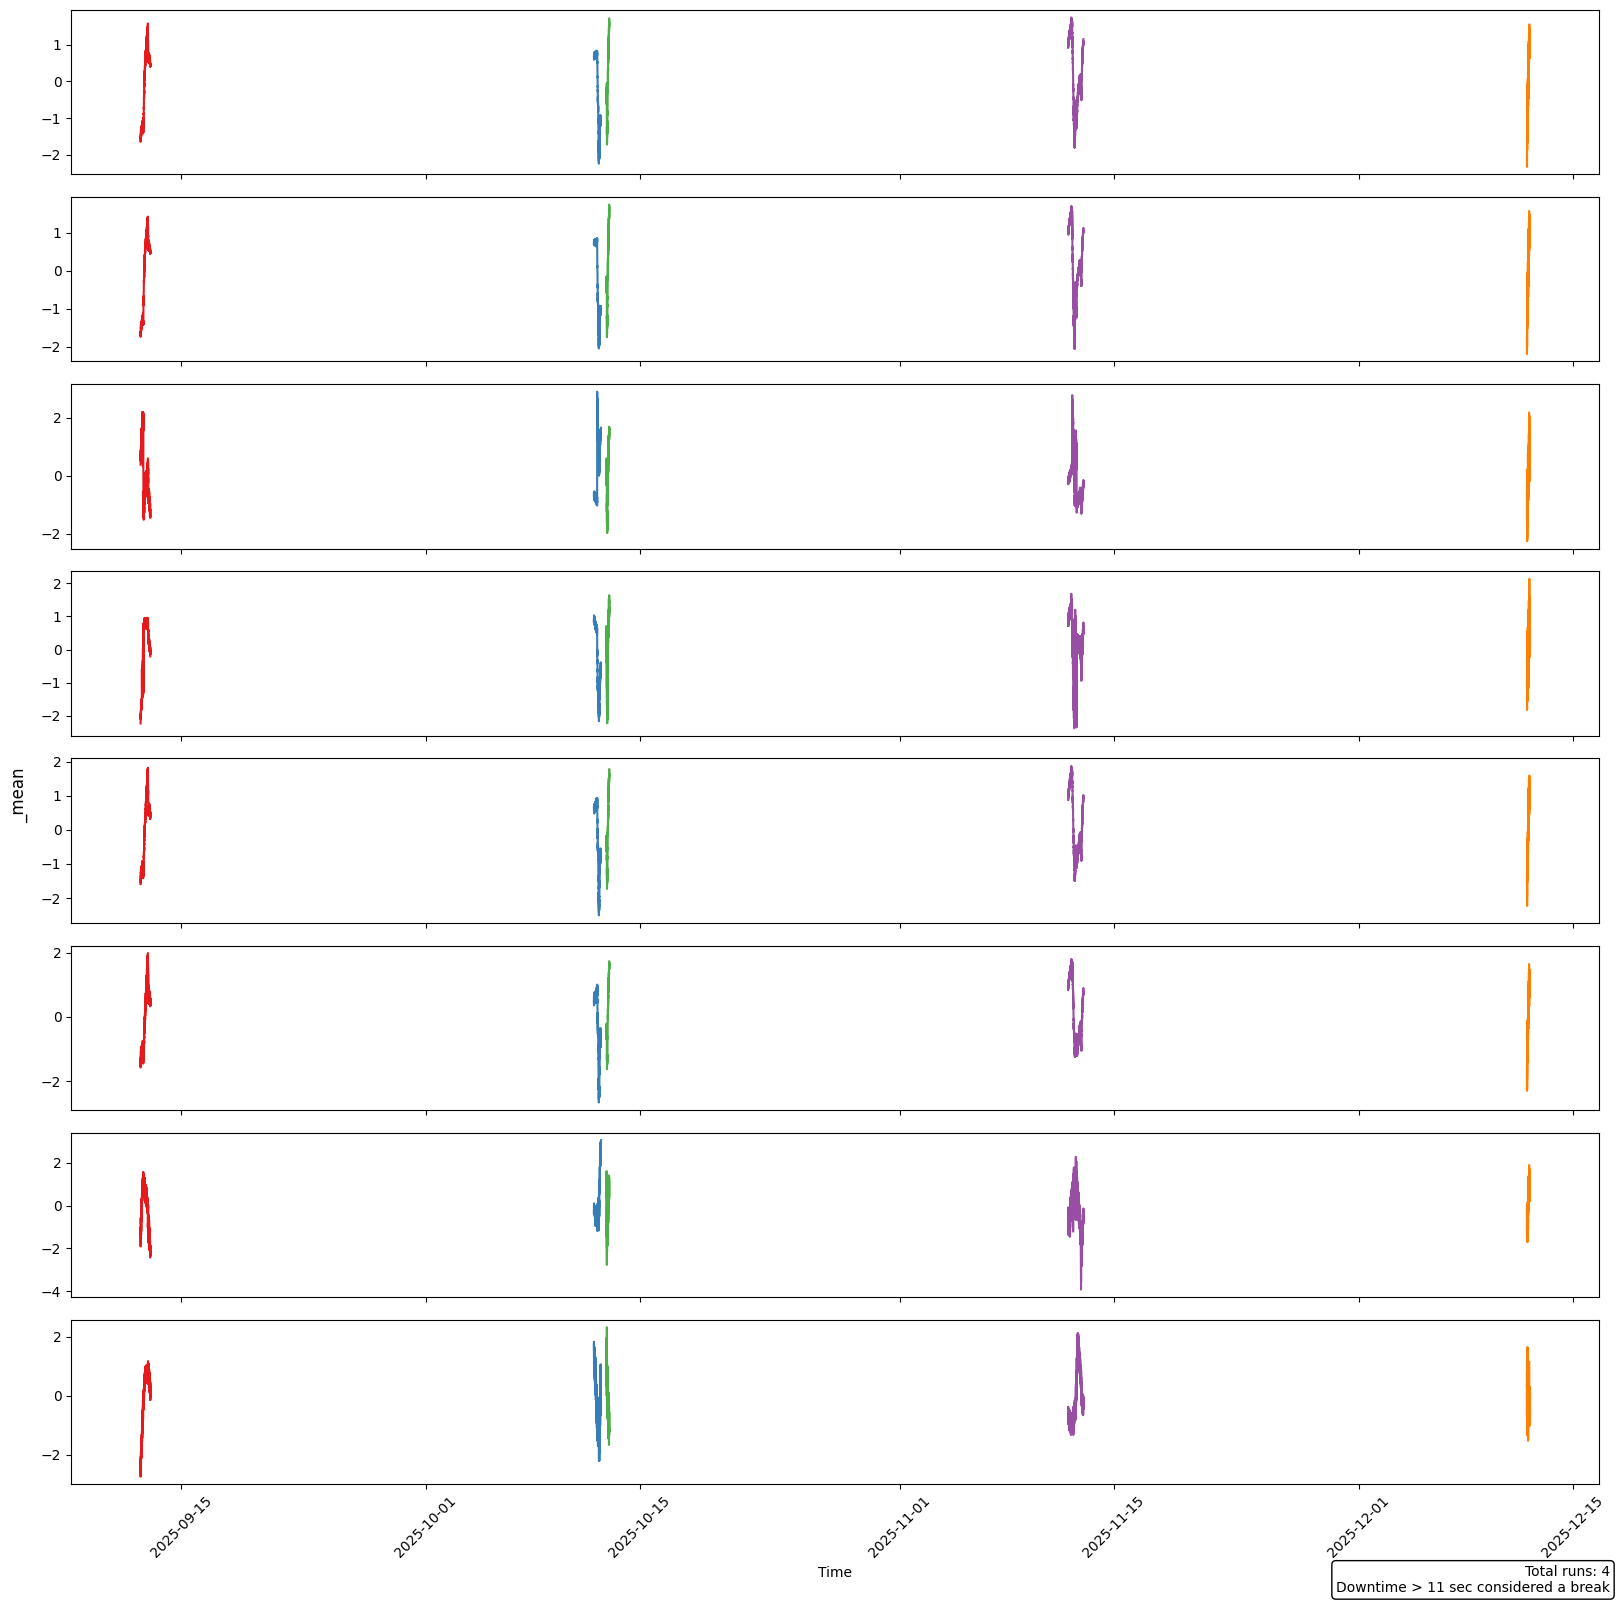

In [160]:

base_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#ffff33", "#a65628", "#f781bf"
]

aero_small['color'] = aero_small['machine_run'].apply(
    lambda x: base_colors[x % len(base_colors)]
)

fig, axes = plt.subplots(
    len(sensors), 1,
    figsize=(16, 2 * len(sensors)),
    sharex=True
)

for i, sensor in enumerate(sensors):
    ax = axes[i]

    # normal runs
    for run_id, group in aero_small.groupby('machine_run'):
        ax.plot(
            group['TimeStr'],
            group[f"{sensor}{features[0]}"],
            c=base_colors[run_id % len(base_colors)],
            label=f'Run {run_id}'
        )

axes[-1].set_xlabel('Time')
plt.xticks(rotation=45)

fig.text(
    -0.01, 0.5,
    f'{features[0]}',
    va='center', rotation='vertical', fontsize=12
)

fig.text(
    0.99, 0.0,
    f"Total runs: {len(gap_indices)}\nDowntime > 11 sec considered a break",
    ha="right", va="bottom",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
)

plt.tight_layout()
plt.show()


In [161]:
target_names

Index(['target_Goedgekeurd_mean', 'target_L_e_mean', 'target_L_v_mean',
       'target_b_gem_mean', 'target_d_gem_mean'],
      dtype='object')

In [162]:
# Dictionary to hold each machine run
df_runs = {}

for run_id in aero_small['machine_run'].unique():
    df_runs[run_id] = aero_small[aero_small['machine_run'] == run_id].copy()
print(len(df_runs.keys()))
df_run0 = df_runs[0]
df_run1 = df_runs[1]
df_run2 = df_runs[2]
df_run3 = df_runs[3]
df_run4 = df_runs[4]
print(len(df_run0),len(df_run1),len(df_run2),len(df_run3),len(df_run4),)

5
1850 1330 544 2880 480


In [170]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# Helper functions
# -------------------------------
def adjusted_r2(r2, n_samples, n_features):
    """Calculate adjusted R²"""
    return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

def train_and_evaluate(X, y, model, future_step=False, test_size=0.2):
    """Train model and return metrics with future-step shift handled correctly"""
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    
    # Split last n_test samples for testing
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    if future_step:
        # Shift y forward by 1
        X_train, y_train = X_train[:-1], y_train[1:]
        X_test, y_test = X_test[:-1], y_test[1:]

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    n_train, n_features = X_train.shape
    n_test = X_test.shape[0]

    metrics = {
        'train_R2': r2_score(y_train, y_pred_train),
        'train_R2_adj': adjusted_r2(r2_score(y_train, y_pred_train), n_train, n_features),
        'train_MSE': mean_squared_error(y_train, y_pred_train),
        'test_R2': r2_score(y_test, y_pred_test),
        'test_R2_adj': adjusted_r2(r2_score(y_test, y_pred_test), n_test, n_features),
        'test_MSE': mean_squared_error(y_test, y_pred_test)
    }

    return metrics, model

def cross_run_eval(model, X_target, y_target, future_step=False):
    """Evaluate model on a different dataset"""
    n_samples = X_target.shape[0]
    n_features = X_target.shape[1]
    n_test = n_samples

    if future_step:
        X_target, y_target = X_target[:-1], y_target[1:]

    y_pred = model.predict(X_target)
    r2 = r2_score(y_target, y_pred)
    r2_adj = adjusted_r2(r2, n_test, n_features)
    mse = mean_squared_error(y_target, y_pred)
    return {'R2': r2, 'R2_adj': r2_adj, 'MSE': mse}

def get_top_features(model, columns, top_n=10):
    """Return top features for tree or linear models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        return pd.DataFrame(columns=['feature', 'importance'])
    
    df = pd.DataFrame({'feature': columns, 'importance': importances})
    df = df.groupby('feature')['importance'].sum().reset_index()
    df = df.sort_values('importance', ascending=False).head(top_n)
    return df

def compute_sensor_importance(top_features, sensors):
    """Map feature importance back to sensors"""
    sensor_imp = []
    for sensor in sensors:
        mask = top_features['feature'].str.startswith(sensor)
        sensor_imp.append({
            'sensor': sensor,
            'importance': top_features.loc[mask, 'importance'].sum()
        })
    return pd.DataFrame(sensor_imp).sort_values('importance', ascending=False)

# -------------------------------
# Models
# -------------------------------
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=800,
        criterion="squared_error",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=1.0,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
        min_samples_leaf=20,
        random_state=42
    ),
    'ElasticNet': ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=10000,
        random_state=42
    ),
    'SVR': SVR(
        kernel='rbf',
        C=100.0,
        epsilon=0.01,
        gamma='scale'
    )
}

# -------------------------------
# Feature and sensor names
# -------------------------------

target_col = 'target_L_e_mean'

# -------------------------------
# Train models on each run
# -------------------------------
results = {}

for run_id, df_run in df_runs.items():
    X = df_run[temp_vars_names].values
    y = df_run[target_col].values

    results[run_id] = {}

    for model_name, model in models.items():
        metrics_curr, fitted_curr = train_and_evaluate(X, y, model, future_step=False)
        metrics_future, fitted_future = train_and_evaluate(X, y, model, future_step=True)

        results[run_id][model_name] = {
            'current': metrics_curr,
            'future': metrics_future,
            'fitted_model_current': fitted_curr,
            'fitted_model_future': fitted_future
        }

# -------------------------------
# Cross-run evaluation
# -------------------------------
cross_run_results = {}

for source_run in df_runs.keys():
    cross_run_results[source_run] = {}
    for model_name in models.keys():
        cross_run_results[source_run][model_name] = {}
        fitted_curr = results[source_run][model_name]['fitted_model_current']
        fitted_future = results[source_run][model_name]['fitted_model_future']

        for target_run, df_target in df_runs.items():
            if target_run == source_run:
                continue
            X_target = df_target[temp_vars_names].values
            y_target = df_target[target_col].values

            cross_run_results[source_run][model_name][target_run] = {
                'current': cross_run_eval(fitted_curr, X_target, y_target, future_step=False),
                'future': cross_run_eval(fitted_future, X_target, y_target, future_step=True)
            }

# -------------------------------
# Compile metrics DataFrames
# -------------------------------
rows_within = []
for run_id, models_dict in results.items():
    for model_name, metrics_dict in models_dict.items():
        for step in ['current', 'future']:
            metrics = metrics_dict[step]
            row = {
                'run_id': run_id,
                'model': model_name,
                'step': step,
                'train_R2': metrics['train_R2'],
                'train_R2_adj': metrics['train_R2_adj'],
                'train_MSE': metrics['train_MSE'],
                'test_R2': metrics['test_R2'],
                'test_R2_adj': metrics['test_R2_adj'],
                'test_MSE': metrics['test_MSE']
            }
            rows_within.append(row)

df_within_run = pd.DataFrame(rows_within)

rows_cross = []
for source_run, models_dict in cross_run_results.items():
    for model_name, target_dict in models_dict.items():
        for target_run, step_dict in target_dict.items():
            for step in ['current', 'future']:
                metrics = step_dict[step]
                row = {
                    'source_run': source_run,
                    'model': model_name,
                    'target_run': target_run,
                    'step': step,
                    'R2': metrics['R2'],
                    'R2_adj': metrics['R2_adj'],
                    'MSE': metrics['MSE']
                }
                rows_cross.append(row)

df_cross_run = pd.DataFrame(rows_cross)

# -------------------------------
# Consolidated Top 10 features & Sensor importance
# -------------------------------
top_features_all_models = {}
sensor_importance_all_models = {}

for model_name in ['RandomForest', 'ElasticNet']:
    all_features = []
    for run_id in df_runs.keys():
        fitted_curr = results[run_id][model_name]['fitted_model_current']
        top_feats = get_top_features(fitted_curr, temp_vars_names, top_n=15)
        all_features.append(top_feats)
    top_features_df = pd.concat(all_features).groupby('feature')['importance'].sum().reset_index()
    top_features_df = top_features_df.sort_values('importance', ascending=False).head(10)
    top_features_all_models[model_name] = top_features_df
    sensor_importance_all_models[model_name] = compute_sensor_importance(top_features_df, sensors)

# -------------------------------
# Print outputs
# -------------------------------
print("===== Within-run metrics =====")
print(df_within_run.head())

print("\n===== Cross-run metrics =====")
print(df_cross_run.head())

print("\n===== Consolidated Top 10 Features Across All Runs =====")
for model_name, df_top in top_features_all_models.items():
    print(f"\nModel: {model_name}")
    print(df_top)
    print('-' * 60)

print("\n===== Sensor Importance Across All Runs =====")
for model_name, df_sensor in sensor_importance_all_models.items():
    print(f"\nModel: {model_name}")
    print(df_sensor)
    print('-' * 60)


c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

===== Within-run metrics =====
   run_id                 model     step  train_R2  train_R2_adj  train_MSE  \
0       0          RandomForest  current  0.929006      0.925795   0.003175   
1       0          RandomForest   future  0.925599      0.922231   0.003329   
2       0  HistGradientBoosting  current  0.993444      0.993148   0.000293   
3       0  HistGradientBoosting   future  0.996673      0.996522   0.000149   
4       0            ElasticNet  current  0.099815      0.059100   0.040259   

        test_R2   test_R2_adj  test_MSE  
0 -7.487847e+25 -9.059068e+25  0.000332  
1 -4.644962e+25 -5.622849e+25  0.000205  
2 -1.076681e+26 -1.302607e+26  0.000477  
3 -4.522608e+25 -5.474736e+25  0.000200  
4 -1.789057e+26 -2.164465e+26  0.000793  

===== Cross-run metrics =====
   source_run         model  target_run     step            R2        R2_adj  \
0           0  RandomForest           1  current -2.994415e+02 -3.146417e+02   
1           0  RandomForest           1   future -2

In [171]:
df_within_run.to_csv('within_run_metrics.csv', index=False)
df_cross_run.to_csv('cross_run_metrics.csv', index=False)

In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# Helper functions
# -------------------------------
def adjusted_r2(r2, n_samples, n_features):
    """Calculate adjusted R²"""
    return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

def train_and_evaluate(X, y, model, future_step=False, test_size=0.2, n_components=None):
    """Train model with optional PCA and return metrics"""
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    
    # Split last n_test samples for testing
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    if future_step:
        X_train, y_train = X_train[:-1], y_train[1:]
        X_test, y_test = X_test[:-1], y_test[1:]

    # Apply PCA if requested
    pca = None
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    n_train, n_features = X_train.shape
    n_test = X_test.shape[0]

    metrics = {
        'train_R2': r2_score(y_train, y_pred_train),
        'train_R2_adj': adjusted_r2(r2_score(y_train, y_pred_train), n_train, n_features),
        'train_MSE': mean_squared_error(y_train, y_pred_train),
        'test_R2': r2_score(y_test, y_pred_test),
        'test_R2_adj': adjusted_r2(r2_score(y_test, y_pred_test), n_test, n_features),
        'test_MSE': mean_squared_error(y_test, y_pred_test)
    }

    return metrics, model, pca

def cross_run_eval(model, X_target, y_target, future_step=False, pca=None):
    """Evaluate model on a different dataset with optional PCA"""
    if future_step:
        X_target, y_target = X_target[:-1], y_target[1:]

    if pca is not None:
        X_target = pca.transform(X_target)

    y_pred = model.predict(X_target)
    n_samples, n_features = X_target.shape
    r2 = r2_score(y_target, y_pred)
    r2_adj = adjusted_r2(r2, n_samples, n_features)
    mse = mean_squared_error(y_target, y_pred)
    return {'R2': r2, 'R2_adj': r2_adj, 'MSE': mse}

def get_top_features(model, columns, top_n=10):
    """Return top features for tree or linear models (note: PCA destroys feature names)"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        return pd.DataFrame(columns=['feature', 'importance'])
    
    df = pd.DataFrame({'feature': columns, 'importance': importances})
    df = df.groupby('feature')['importance'].sum().reset_index()
    df = df.sort_values('importance', ascending=False).head(top_n)
    return df

def compute_sensor_importance(top_features, sensors):
    """Map feature importance back to sensors"""
    sensor_imp = []
    for sensor in sensors:
        mask = top_features['feature'].str.startswith(sensor)
        sensor_imp.append({
            'sensor': sensor,
            'importance': top_features.loc[mask, 'importance'].sum()
        })
    return pd.DataFrame(sensor_imp).sort_values('importance', ascending=False)

# -------------------------------
# Models
# -------------------------------
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=800,
        criterion="squared_error",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=1.0,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
        min_samples_leaf=20,
        random_state=42
    ),
    'ElasticNet': ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=10000,
        random_state=42
    ),
    'SVR': SVR(
        kernel='rbf',
        C=100.0,
        epsilon=0.01,
        gamma='scale'
    )
}

# -------------------------------
# Training with PCA
# -------------------------------
results = {}
n_pca_components = 20  # adjust as needed

for run_id, df_run in df_runs.items():
    X = df_run[temp_vars_names].values
    y = df_run[target_col].values

    results[run_id] = {}

    for model_name, model in models.items():
        metrics_curr, fitted_curr, pca_curr = train_and_evaluate(X, y, model, future_step=False, n_components=n_pca_components)
        metrics_future, fitted_future, pca_future = train_and_evaluate(X, y, model, future_step=True, n_components=n_pca_components)

        results[run_id][model_name] = {
            'current': metrics_curr,
            'future': metrics_future,
            'fitted_model_current': fitted_curr,
            'fitted_model_future': fitted_future,
            'pca_current': pca_curr,
            'pca_future': pca_future
        }

# -------------------------------
# Cross-run evaluation with PCA
# -------------------------------
cross_run_results = {}

for source_run in df_runs.keys():
    cross_run_results[source_run] = {}
    for model_name in models.keys():
        cross_run_results[source_run][model_name] = {}
        fitted_curr = results[source_run][model_name]['fitted_model_current']
        fitted_future = results[source_run][model_name]['fitted_model_future']
        pca_curr = results[source_run][model_name]['pca_current']
        pca_future = results[source_run][model_name]['pca_future']

        for target_run, df_target in df_runs.items():
            if target_run == source_run:
                continue
            X_target = df_target[temp_vars_names].values
            y_target = df_target[target_col].values

            cross_run_results[source_run][model_name][target_run] = {
                'current': cross_run_eval(fitted_curr, X_target, y_target, future_step=False, pca=pca_curr),
                'future': cross_run_eval(fitted_future, X_target, y_target, future_step=True, pca=pca_future)
            }

# -------------------------------
# Compile metrics DataFrames (PCA results)
# -------------------------------
rows_within = []
for run_id, models_dict in results.items():
    for model_name, metrics_dict in models_dict.items():
        for step in ['current', 'future']:
            metrics = metrics_dict[step]
            row = {
                'run_id': run_id,
                'model': model_name,
                'step': step,
                'train_R2': metrics['train_R2'],
                'train_R2_adj': metrics['train_R2_adj'],
                'train_MSE': metrics['train_MSE'],
                'test_R2': metrics['test_R2'],
                'test_R2_adj': metrics['test_R2_adj'],
                'test_MSE': metrics['test_MSE']
            }
            rows_within.append(row)

df_within_run = pd.DataFrame(rows_within)
df_within_run.to_csv('within_run_metrics_pca.csv', index=False)

rows_cross = []
for source_run, models_dict in cross_run_results.items():
    for model_name, target_dict in models_dict.items():
        for target_run, step_dict in target_dict.items():
            for step in ['current', 'future']:
                metrics = step_dict[step]
                row = {
                    'source_run': source_run,
                    'model': model_name,
                    'target_run': target_run,
                    'step': step,
                    'R2': metrics['R2'],
                    'R2_adj': metrics['R2_adj'],
                    'MSE': metrics['MSE']
                }
                rows_cross.append(row)

df_cross_run = pd.DataFrame(rows_cross)
df_cross_run.to_csv('cross_run_metrics_pca.csv', index=False)

c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca